# Nelder-Mead法( アメーバ法 )
## 1. 概要
$n$次元の変数に対し, $n+1$頂点の単体(シンプレックス)を生成し,それをアメーバのように動かしながら , 探索を行う.
( 例 : 2次元の変数 &rarr; 三角形 , 3次元の変数 &rarr; 四面体 )

## 2. 特徴
- 連続最適化 , 制約なし ,導関数不要.
- 局所最適解に収束する.
- 目的関数の次数が小さい時は使える . 大きいと実行時間的に使えない.

## 3. 詳細
- [Wikipedia](https://ja.wikipedia.org/wiki/%E3%83%8D%E3%83%AB%E3%83%80%E3%83%BC%E2%80%93%E3%83%9F%E3%83%BC%E3%83%89%E6%B3%95)にアルゴリズムの記述あり.
- (https://postd.cc/numerical-optimization/)
- [Animation](http://www.benfrederickson.com/numerical-optimization/)

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from copy import copy,deepcopy
from functools import reduce
%matplotlib nbagg
#%matplotlib inline
# required : 
def f(x):
    return np.log(1 + pow(abs(x),2+np.sin(x)))

# 初期パラメータ
# step : 初期の単体の辺の長さ.( 変形の大きさ ) 
# alpha : 反射点の拡大率 ( alpha = 1.0 がdefault , alpha大ほど反射時の膨張率大  )
# gamma : 反射拡大点の拡大率 (gamma > alpha , gamma = 2.0がdefault , gamma大ほど膨張率大 )
# rho : 収縮点の収縮率 ( rho = 0.5 が default , rho大ほど最悪点の収縮率大 )
# sigma : 最良点を中心に全体を収縮させる時の収縮率 ( sigma = 0.5 が default , sigma大ほど収縮率大 )
step,alpha , gamma , rho , sigma = 0.1,1,2,0.5,0.5
x_start = np.array( [-5.0])
dim = len(x_start)

In [73]:
# init : 
x_n = [ x_start ]
for i in range(dim):
    x_i = copy(x_start)
    x_i[i] += step
    x_n.append(x_i)
x_n = np.array(x_n)
f_n = np.array(list(map(lambda x: f(*x),x_n)))
print(x_n)
print(f_n)

[[-5. ]
 [-4.9]]
[ 4.77071533  4.74852095]


<IPython.core.display.Javascript object>


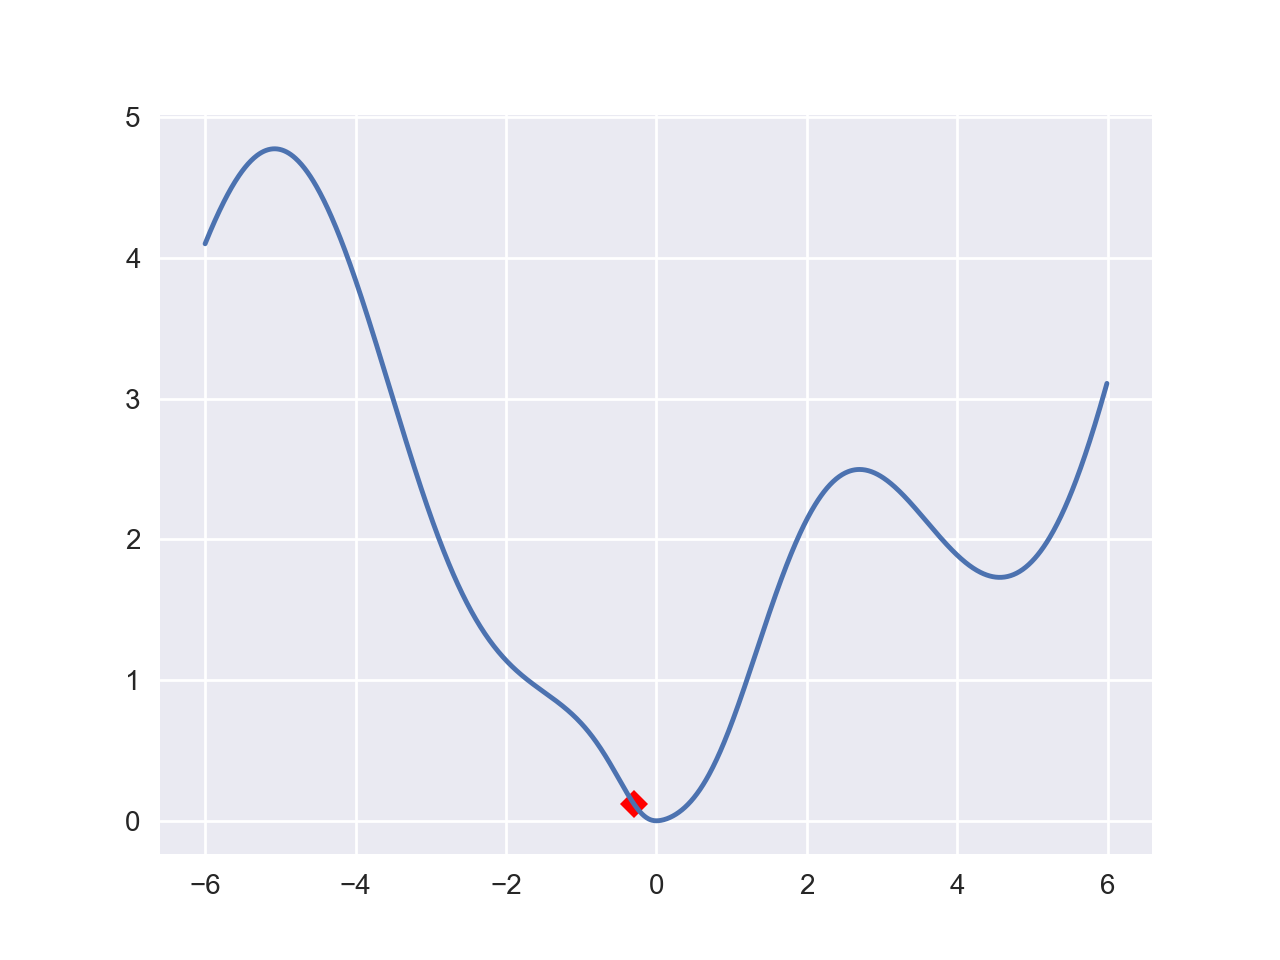

In [74]:
# アニメーション用
fig = plt.figure()
ims = []

In [75]:
# roop
maxIter = 100
eps = 1e-6
prev_best = float('inf')

iterator = 0
notUpdate = 0
while True:
    iterator += 1
    # fの値で昇順ソートを行う.
    #x_n[0] : 最良点 , x_n[dim] : 最悪点 となる.
    sortedIndex = np.argsort(f_n)
    x_n = x_n[sortedIndex]
    f_n = f_n[sortedIndex]
    
    # 現在のスコア
    cur_best = f(*x_n[0])
    print("Iterator : {0} , Score : {1}".format(iterator,cur_best))
    
    # animation ########################
    im = plt.plot(x_n[0],[cur_best],'D',color='r')
    ims.append(im)
    ################################
    # 最良点の更新が行われない.
    if abs(cur_best - prev_best) < 1e-10:
        notUpdate += 1
        
    # イテレータが一定回数以上で終了 or 最良点の更新がループ10回以上行われない.
    if iterator > maxIter or notUpdate > 10:
        break
    
    
    # スコア更新
    prev_best = cur_best
    # 重心を求める
    x_g = np.sum(x_n[:-1],axis=0) / dim
    # xの大きさ : x_n[0] <= x_r < x_g(平均) < x_n[dim]
    #  ( WorstPoint( x_n[dim] ) の 重心( x_g ) に対する ) 反射点 を求める. 
    # 反射点x_r は 線分 x_g--x_n[dim] を (1+alpha) : alpha に外分する点.( alpha = 1.0 の時 , x_r と x_n[dim] が対称位置)
    x_r = x_g + alpha * ( x_g - x_n[dim])
    f_r = f(*x_r)
    
    if f_n[0] <= f_r < f_n[dim-1]:
        # 反射 : WorstPointを捨てて,反射点を採用
        x_n[dim] = x_r
        f_n[dim] = f_r
    elif f_r < f_n[0]:
        # 反射点のスコアがBestPointよりも良い.
        # 膨張 : 最悪点を重心点に対して折り返して膨張させる.
        # 反射拡大点を求める.
        # 反射拡大点x_eは 線分 x_g--x_n[dim]を (1+gamma) : gamma に外分する点. 
        # ( alpha < gamma より ,反射点より x_g から遠い )
        x_e = x_g + gamma * (x_g - x_n[dim])
        if f(*x_e) < f_r:
            # 反射拡大点のスコアが良いので,採用
            x_n[dim] = x_e
            f_n[dim] = f(*x_e)
        else:
            # 反射点を採用(結局, 反射と同じ操作)
            x_n[dim] = x_r
            f_n[dim] = f(*x_r)
    else: 
        # f_r >= f_n[dim-1]
        # 収縮 : 反射点が第二最悪点よりも悪いとき, 最悪点を重心に近づける(単体が収縮する)
        # 収縮点を求める.
        # 収縮点 x_c は 線分 x_g--x_n[dim] を (1-rho) : rho に内分する点.
        x_c = x_g - rho * (x_g - x_n[dim])
        if f(*x_c) < f_n[dim]:
            # 収縮点が最悪点より良ければ , 収縮点を採用する.
            x_n[dim] = x_c
            f_n[dim] = f(*x_c)
        else:
            # 収縮点がさらに悪くなってしまったら, 全ての点を最良点を中心に収縮させる.
            # なお, 各収縮点 x*_i は , 線分x_g--x_n[i] を (1-sigma) : sigma に内分する点
            x_0 = x_n[0]
            x_n = np.array( [ x_0 - sigma*(x_n[i] - x_0) if i != 0 else x_0 for i in range(dim+1) ])
            f_n = np.array(list(map(lambda x: f(*x),x_n)))

print("RESULT")
print("X")
print(x_n[0])
print("f(x)")
print(cur_best)

Iterator : 1 , Score : 4.748520945605997
Iterator : 2 , Score : 4.652155582799668
Iterator : 3 , Score : 4.267676873944691
Iterator : 4 , Score : 2.9962407160266933
Iterator : 5 , Score : 1.0874266056223763
Iterator : 6 , Score : 0.12085277745246184
Iterator : 7 , Score : 0.12085277745246184
Iterator : 8 , Score : 0.12085277745246184
Iterator : 9 , Score : 0.007914923941070297
Iterator : 10 , Score : 0.007914923941070297
Iterator : 11 , Score : 0.0
Iterator : 12 , Score : 0.0
Iterator : 13 , Score : 0.0
Iterator : 14 , Score : 0.0
Iterator : 15 , Score : 0.0
Iterator : 16 , Score : 0.0
Iterator : 17 , Score : 0.0
Iterator : 18 , Score : 0.0
Iterator : 19 , Score : 0.0
RESULT
X
[ -1.77635684e-14]
f(x)
0.0


In [76]:
x =np.arange(-6.0,6.0,step=0.01)
y = np.vectorize(f)(x)
plt.plot(x,y)
ani = animation.ArtistAnimation(fig,ims,interval=100)
plt.show()